# Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})



import os 
path_to_class_sz = os.getcwd() + '/../../class_sz/'

    
# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf) Table 2
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

}


Metal device set to: Apple M1 Pro


2023-04-05 16:09:36.494970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 16:09:36.495112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## choose unWISE sample (blue, green, red)

In [2]:
color = "blue"

# unWISE HOD dictionary 

In [13]:
# best-fit from Kusiak et al. https://arxiv.org/pdf/2203.12583.pdf

HOD_blue = {
'sigma_log10M_HOD': 0.68660116,
'alpha_s_HOD':    1.3039425,
'M1_prime_HOD': 10**12.701308, # Msun/h
'M_min_HOD': 10**11.795964, # Msun/h
'M0_HOD' :0,
'x_out_truncated_nfw_profile_satellite_galaxies':  1.0868995,
'f_cen_HOD' : 1., 
    
'galaxy_sample': 'unwise',
'galaxy_sample_id': "blue",
'UNWISE_dndz_file': path_to_class_sz +"/class_sz_auxiliary_files/normalised_dndz_cosmos.txt"
}

HOD_green = {
'alpha_s_HOD':  1.3023026,
'sigma_log10M_HOD':0.97260617,
'M1_prime_HOD': 10**13.440975,
'M_min_HOD':10**13.127660,
'M0_HOD' :0,
'x_out_truncated_nfw_profile_satellite_galaxies':2.7461961,
'f_cen_HOD' : 1., 
    
'galaxy_sample': 'unwise',
'galaxy_sample_id': "green",
'UNWISE_dndz_file': path_to_class_sz +"/class_sz_auxiliary_files/normalised_dndz_cosmos.txt"
}

HOD_red = {

'sigma_log10M_HOD' :  0.40339510,
'alpha_s_HOD' :   1.6292653,
'M1_prime_HOD':  10** 13.518607,
'M_min_HOD': 10** 12.707242,
'M0_HOD' :0,
'x_out_truncated_nfw_profile_satellite_galaxies': 0.18379845,
'f_cen_HOD' : 1., 
    
'galaxy_sample': 'unwise',
'galaxy_sample_id': "red",
'UNWISE_dndz_file': path_to_class_sz +"/class_sz_auxiliary_files/normalised_dndz_cosmos.txt"
}

unWISE_common = {
'z_min': 0.005,
'z_max': 4,
'M_min': 1.0e10,
'M_max': 3.5e15,
    
# 'dlogell': 0.3,
'ell_max' : 9950.0,
'ell_min' : 50,
'dlogell': 0.1,  
    
# precisions params:
# 'k_min_for_pk_class_sz' :  0.001,
# 'k_max_for_pk_class_sz' :  60.0,
# 'k_per_decade_class_sz' :  50,
# 'P_k_max_h/Mpc' :  50.0,

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,
# 'ndim_masses': 150,
'ndim_redshifts': 80,

'hm_consistency': 1,
'delta for galaxies': "200c",
# 'delta for matter density': "200c",
'mass function': 'T08M200c', #Tinker 2008 for 200c mass def

#common hod params
'M0 equal M_min (HOD)':'no',
'x_out_truncated_nfw_profile': 1.0,
}


In [14]:
if color=="blue":
    HOD_dict = HOD_blue
if color=="green":
    HOD_dict = HOD_green
if color=="red":
    HOD_dict = HOD_red 

# Pressure profile dictionary 

In [43]:
# Battaglia et al. 2012 pressure profile

pp_B12 = {
        'pressure profile': 'B12', 
        'x_outSZ': 4,
        'truncate_wrt_rvir': 0,
        'P0_B12': 11.,
        'concentration parameter': 'B13',
        'delta for electron pressure':'200c',
        #pressure precision
        'n_z_pressure_profile': 80,

        'use_fft_for_profiles_transform' : 1,

        'N_samp_fftw' : 1024,
        'x_min_gas_pressure_fftw' : 1e-4,
        'x_max_gas_pressure_fftw' : 1e3,       
}


# Arnaud et al. 2010 pressure profile arXiv:0910.1234 
pp_a10 = {
        'pressure profile': 'A10', 
        'B': 1.7, #hydrostatic equilibrium bias (1-b)^-1     
        'concentration parameter': 'B13',
        # 'delta for electron pressure':'200c',
        # #pressure precision
        # 'n_z_dydz' : 500,
        # 'n_z_pressure_profile': 80,
        # 'n_m_pressure_profile' : 80,
        # 'n_ell_pressure_profile' : 80,
        # 'pressure_profile_epsrel':1e-4,
        # 'pressure_profile_epsabs':1e-100
}

# Compton y - galaxy power spectra (B12)

In [44]:
%%time
M = Class()
M.set(cosmo_params)
M.set(unWISE_common)
M.set(HOD_dict) 
M.set(pp_B12) 

M.set({
'output' : 'tSZ_gal_1h, tSZ_gal_2h',
'mass function':'T08M200c'
})
      
M.compute_class_szfast()

cl_yg_b12 = M.cl_yg()

cl_ell_b12=np.array(cl_yg_b12['ell'])
cl_1h_b12=np.array(cl_yg_b12['1h'])
cl_2h_b12=np.array(cl_yg_b12['2h'])

cl_tot_b12=cl_1h_b12+cl_2h_b12

M.struct_cleanup()
M.empty()

CPU times: user 2.08 s, sys: 135 ms, total: 2.22 s
Wall time: 555 ms


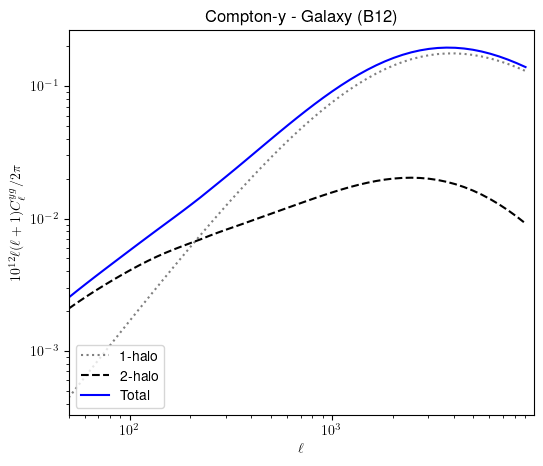

In [45]:
# path_save= "/Users/aleksandra/Desktop/"

plt.figure(figsize=(6,5))
plt.xscale('log')
plt.yscale('log')

plt.plot(cl_ell_b12, cl_1h_b12, c='grey', label='1-halo', ls=':')
plt.plot(cl_ell_b12, cl_2h_b12, c='black', label='2-halo', ls='--')
plt.plot(cl_ell_b12, cl_tot_b12, c=color, label='Total')

plt.xlim([50, 9950])
plt.ylabel(r'$10^{12}\ell(\ell+1)C_{\ell}^{yg}/2\pi$')
plt.xlabel('$\ell$')
plt.title('Compton-y - Galaxy (B12)')
plt.legend(loc='lower left')
# plt.savefig(path_save+'class_sz_tutorial_notebooks/figures/yg_unwise_'+color+'_b12.pdf')

# Compton y - galaxy power spectra (A10)

In [46]:
%%time
M = Class()
M.set(cosmo_params)
M.set(unWISE_common)
M.set(HOD_dict) 
M.set(pp_a10) 

M.set({
'output' : 'tSZ_gal_1h, tSZ_gal_2h',
})
      
M.compute()

cl_yg_a10 = M.cl_yg()

cl_ell_a10=np.array(cl_yg_a10['ell'])
cl_1h_a10=np.array(cl_yg_a10['1h'])
cl_2h_a10=np.array(cl_yg_a10['2h'])

cl_tot_a10=cl_1h_a10+cl_2h_a10

M.struct_cleanup()
M.empty()

CPU times: user 11.1 s, sys: 26.3 ms, total: 11.1 s
Wall time: 1.42 s


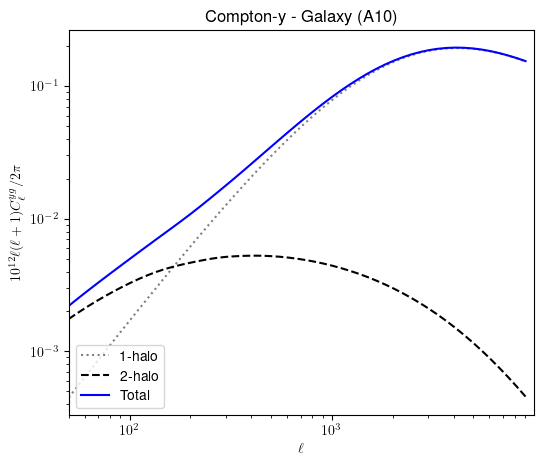

In [47]:
plt.figure(figsize=(6,5))
plt.xscale('log')
plt.yscale('log')

plt.plot(cl_ell_a10, cl_1h_a10, c='grey', label='1-halo', ls=':')
plt.plot(cl_ell_a10, cl_2h_a10, c='black', label='2-halo', ls='--')
plt.plot(cl_ell_a10, cl_tot_a10, c=color, label='Total')

plt.xlim([50, 9950])
plt.ylabel(r'$10^{12}\ell(\ell+1)C_{\ell}^{yg}/2\pi$')
plt.xlabel('$\ell$')
plt.title('Compton-y - Galaxy (A10)')
plt.legend(loc='lower left')
plt.legend(loc='lower left')
# plt.savefig(path_save+'class_sz_tutorial_notebooks/figures/yg_unwise_'+color+'_a10.pdf')

# Compare different pressure profiles 

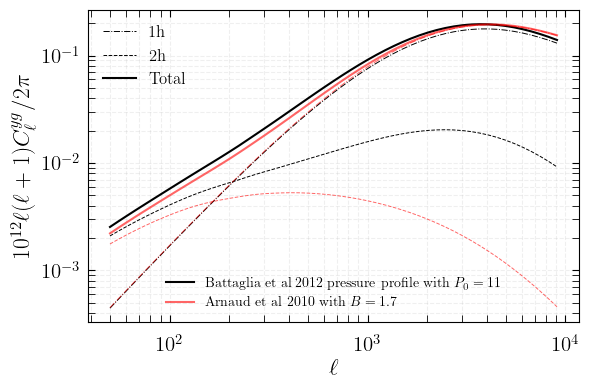

In [51]:
label_size = 15
title_size = 17
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"$\ell$ ",size=title_size,labelpad=2)
ax.set_ylabel(r'$10^{12}\ell(\ell+1)C_{\ell}^{yg}/2\pi$',size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')


ax.plot(cl_ell_b12, cl_1h_b12,  label=r'$1\mathrm{h}$', ls='-.',lw=0.7,c='k')
ax.plot(cl_ell_b12, cl_2h_b12, label=r'$2\mathrm{h}$', ls='--',lw=0.7,c='k')
l1,= ax.plot(cl_ell_b12, cl_tot_b12, label=r'$\mathrm{Total}$', ls='-',c='k')
leg1=plt.legend(ncol=1,frameon=False,fontsize=12,loc=2)


ax.plot(cl_ell_a10, cl_1h_a10, c='r', label=r'$1\mathrm{h}$', ls='-.',lw=0.7,alpha=0.6)
ax.plot(cl_ell_a10, cl_2h_a10, c='r', label=r'$2\mathrm{h}$', ls='--',lw=0.7,alpha=0.6)
l2,= ax.plot(cl_ell_a10, cl_tot_a10, c='r', label=r'$\mathrm{Total}$', ls='-',alpha=0.6)
#plt.plot(cl_ell_gnfw, cl_tot_gnfw, c='black', label='GNW', ls='--')

# plt.ylim(2e-3,3e-1)
# plt.ylabel(r'$10^{12}\ell(\ell+1)C_{\ell}^{yg}/2\pi$')
# plt.xlabel('$\ell$')
# plt.title('Compton-y - Galaxy')
leg2=plt.legend([l1,l2],[r"$\mathrm{Battaglia\,\, et\,\, al\, 2012\,\, pressure\,\, profile\,\, with}$ $P_0=11$",
                         r"$\mathrm{Arnaud\,\,et\,\,al\,\,2010\,\,with}$ $B=1.7$"],
                frameon=False,fontsize = 10)
ax.add_artist(leg1)
plt.tight_layout()
# plt.legend(loc='lower left')


plt.savefig('figures/classyg_unwise_blue_compare_pp.pdf')